# DATA SCIENCE SESSIONS VOL. 3
### A Foundational Python Data Science Course
## Session 16: Binomial Logistic Regression. MLEs for Binomial Logistic Regression. Multinomial Regression

[&larr; Back to course webpage](https://datakolektiv.com/)

Feedback should be send to [goran.milovanovic@datakolektiv.com](mailto:goran.milovanovic@datakolektiv.com). 

These notebooks accompany the DATA SCIENCE SESSIONS VOL. 3 :: A Foundational Python Data Science Course.

![](../img/IntroRDataScience_NonTech-1.jpg)

### Lecturers

[Goran S. Milovanović, PhD, DataKolektiv, Chief Scientist & Owner](https://www.linkedin.com/in/gmilovanovic/)

[Aleksandar Cvetković, PhD, DataKolektiv, Consultant](https://www.linkedin.com/in/alegzndr/)

[Ilija Lazarević, MA, DataKolektiv, Consultant](https://www.linkedin.com/in/ilijalazarevic/)

![](../img/DK_Logo_100.png)

***

In [93]:
### --- Setup - importing the libraries

# - supress those annoying 'Future Warning'
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# - data
import numpy as np
import pandas as pd

# - os
import os

# - ml
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor



# - visualization
import matplotlib.pyplot as plt
import seaborn as sns

# - parameters
%matplotlib inline
pd.options.mode.chained_assignment = None  # default='warn'
sns.set_theme()
# - rng
rng = np.random.default_rng()
# - plots
plt.rc("figure", figsize=(8, 6))
plt.rc("font", size=14)
sns.set_theme(style='white')

# - directory tree
data_dir = os.path.join(os.getcwd(), '_data')

## 1. Binomial Logistic Regression

In [2]:
# - loading the dataset
# - GitHub: https://github.com/dijendersaini/Customer-Churn-Model/blob/master/churn_data.csv
# - place it in your _data/ directory
churn_data = pd.read_csv(os.path.join(data_dir, 'churn_data.csv'))
churn_data.head(10)

,customerID,tenure,PhoneService,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,1,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,34,Yes,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,2,Yes,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,45,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,2,Yes,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
5,9305-CDSKC,8,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,Yes
6,1452-KIOVK,22,Yes,Month-to-month,Yes,Credit card (automatic),89.10,1949.4,No
7,6713-OKOMC,10,No,Month-to-month,No,Mailed check,29.75,301.9,No
8,7892-POOKP,28,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes
9,6388-TABGU,62,Yes,One year,No,Bank transfer (automatic),56.15,3487.95,No


### Data Preparation

In [3]:
churn_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   tenure            7043 non-null   int64  
 2   PhoneService      7043 non-null   object 
 3   Contract          7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   Churn             7043 non-null   object 
dtypes: float64(1), int64(1), object(7)
memory usage: 495.3+ KB


In [4]:
# - some entries have missing values given as empty strings
churn_data.loc[488]

customerID                         4472-LVYGI
tenure                                      0
PhoneService                               No
Contract                             Two year
PaperlessBilling                          Yes
PaymentMethod       Bank transfer (automatic)
MonthlyCharges                          52.55
TotalCharges                                 
Churn                                      No
Name: 488, dtype: object

In [5]:
# - use .replace method to replace empty strings with NaN values
churn_data = churn_data.replace(r'^\s*$', np.nan, regex=True)
churn_data.loc[488]

customerID                         4472-LVYGI
tenure                                      0
PhoneService                               No
Contract                             Two year
PaperlessBilling                          Yes
PaymentMethod       Bank transfer (automatic)
MonthlyCharges                          52.55
TotalCharges                              NaN
Churn                                      No
Name: 488, dtype: object

In [6]:
# - we drop all the entries with missing values
churn_data = churn_data.dropna().reset_index(drop=True)

In [7]:
churn_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7032 non-null   object 
 1   tenure            7032 non-null   int64  
 2   PhoneService      7032 non-null   object 
 3   Contract          7032 non-null   object 
 4   PaperlessBilling  7032 non-null   object 
 5   PaymentMethod     7032 non-null   object 
 6   MonthlyCharges    7032 non-null   float64
 7   TotalCharges      7032 non-null   object 
 8   Churn             7032 non-null   object 
dtypes: float64(1), int64(1), object(7)
memory usage: 494.6+ KB


In [8]:
# - notice that 'TotalCharges' values are non-numeric type, but they should be
# - this is due to the empty string values that were previously present
# - we convert them to numeric type
churn_data['TotalCharges'] =churn_data['TotalCharges'].astype('float')
churn_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7032 non-null   object 
 1   tenure            7032 non-null   int64  
 2   PhoneService      7032 non-null   object 
 3   Contract          7032 non-null   object 
 4   PaperlessBilling  7032 non-null   object 
 5   PaymentMethod     7032 non-null   object 
 6   MonthlyCharges    7032 non-null   float64
 7   TotalCharges      7032 non-null   float64
 8   Churn             7032 non-null   object 
dtypes: float64(2), int64(1), object(6)
memory usage: 494.6+ KB


### Target: Predict churn from all numeric predictors

We use Binomial Logistic Regression to predict the probability $p$ of a given observation $\textbf{x}$, with features $(x_1, x_2, \ldots, x_k)$, belonging to one of the two binary categories \{0, 1\}. We compute these probabilites via

$$p = \frac{1}{1+e^{\beta_1x_1 + \beta_2x_2 + \cdots + \beta_kx_k + \beta_0}},$$

where $\beta_1, \beta_2, \ldots, \beta_k$ are the model's parameters for the predictors, and $\beta_0$ is the intercept of the model.

In order to determine whether the predicted label $\hat{y}$ for a given observation $\textbf{x}$ has binary label 1 or 0, we impose a decision criterion $\sigma$ - a number in the (0, 1) interval. If $p > \sigma$, then we assign label $\hat{y} = 1$ to the observation $\textbf{x}$; else, we take $\hat{y} = 0$. Ususally, we take $\sigma = 0.5$.

The model is optimized by MLE (Maximum Likelihood Estimation), and the interpretation of the model coefficients is the following:

- for a given predictor $x_i$, the exponential of its coefficient, $e^{\beta_i}$ tells us about the change $\Delta_{odds}$, where $\Delta_{odds}$ is the difference between $\frac{p_1}{1-p_1}$ *following* a unit increase in $x_i$ and before it - given that everything else is kept constant.

In [9]:
### --- Preparing the model frame

# - extracting 'Churn' and all the numerical features columns
model_frame = churn_data[['Churn', 'tenure', 'MonthlyCharges', 'TotalCharges']]
model_frame.head()

,Churn,tenure,MonthlyCharges,TotalCharges
0,No,1,29.85,29.85
1,No,34,56.95,1889.50
2,Yes,2,53.85,108.15
3,No,45,42.30,1840.75
4,Yes,2,70.70,151.65


In [10]:
# - encoding 'Churn' values to binary values
model_frame['Churn'] = model_frame['Churn'].apply(lambda x: int(x == 'Yes'))
model_frame.head()

,Churn,tenure,MonthlyCharges,TotalCharges
0,0,1,29.85,29.85
1,0,34,56.95,1889.50
2,1,2,53.85,108.15
3,0,45,42.30,1840.75
4,1,2,70.70,151.65


In [11]:
predictors = model_frame.columns.drop('Churn')
predictors

Index(['tenure', 'MonthlyCharges', 'TotalCharges'], dtype='object')

In [12]:
# --- Composing the fomula of the model

# - right side of the formula
formula = ' + '.join(predictors)

# - left side of the formula
formula = 'Churn ~ ' + formula

formula

'Churn ~ tenure + MonthlyCharges + TotalCharges'

In [13]:
# - fitting BLR model to the data
binomial_linear_model = smf.logit(formula=formula, data=model_frame).fit()

Optimization terminated successfully.
         Current function value: 0.453372
         Iterations 7


In [14]:
binomial_linear_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  Churn   No. Observations:                 7032
Model:                          Logit   Df Residuals:                     7028
Method:                           MLE   Df Model:                            3
Date:                Mon, 24 Apr 2023   Pseudo R-squ.:                  0.2170
Time:                        17:19:18   Log-Likelihood:                -3188.1
converged:                       True   LL-Null:                       -4071.7
Covariance Type:            nonrobust   LLR p-value:                     0.000
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -1.5988      0.117    -13.628      0.000      -1.829      -1.369
tenure            -0.0671      0.005    -12.297      0.000      -0.078      -0.056
MonthlyCharges     0.0302      0.002     17.585      0.000       0.027       0.034
TotalCharges       0.0001   6.14e-05      2.361      0.018    2.47e-05       0.000
==================================================================================
"""

In [15]:
# - model's parameters
binomial_linear_model.params

Intercept        -1.598827
tenure           -0.067114
MonthlyCharges    0.030200
TotalCharges      0.000145
dtype: float64

In [16]:
# - exponential of the model's parameters
np.exp(binomial_linear_model.params)

Intercept         0.202133
tenure            0.935088
MonthlyCharges    1.030660
TotalCharges      1.000145
dtype: float64

In [17]:
# - predicting the probabilities
probabilities = binomial_linear_model.predict()
probabilities[:10]

array([0.31861382, 0.13162129, 0.47723817, 0.04417324, 0.60445587,
       0.72962176, 0.47459352, 0.2095354 , 0.53216748, 0.02770232])

In [18]:
# - predicting binary labels, taking \sigma = 0.5
predictions = (probabilities > .5).astype('int')
predictions[:10]

array([0, 0, 0, 0, 1, 1, 0, 0, 1, 0])

In [19]:
# - observed vs. predicted labels

predictions_df = pd.DataFrame()

predictions_df['observation'] = model_frame['Churn']
predictions_df['prediction'] = predictions

predictions_df.head()

,observation,prediction
0,0,0
1,0,0
2,1,0
3,0,0
4,1,1


In [20]:
# - accuracy of the model
accuracy = predictions_df['observation'] == predictions_df['prediction']
accuracy = np.sum(accuracy)/len(accuracy)
np.round(accuracy, 4)

0.785

In [21]:
# - model true positive rate (hit rate)
hit = (predictions_df['observation'] == 1)&(predictions_df['prediction'] == 1)
hit = np.sum(hit)/np.sum(predictions_df['observation'] == 1)
np.round(hit, 4)

0.4425

In [22]:
# - model false positive rate (fallse alarm rate)
fa = (predictions_df['observation'] == 0)&(predictions_df['prediction'] == 1)
fa = np.sum(fa)/np.sum(predictions_df['observation'] == 0)
np.round(fa, 4)

0.091

In [23]:
### --- Constructing the ROC curve of the model

# - calculating model metrics for varying decision criteria \sigma
dec_criterion = np.arange(.01, .99, step=.01)

observations = model_frame['Churn']

hits = []
fas = []
accuracies = []

for x in dec_criterion:
    
    predictions =  probabilities > x
    
    accuracy = np.sum(observations == predictions)/len(observations)
    hit = np.sum((observations == 1)&(predictions == 1))/np.sum(observations == 1)
    fa = np.sum((observations == 0)&(predictions == 1))/np.sum(observations == 0)
    
    accuracies.append(accuracy)
    fas.append(fa)
    hits.append(hit)

In [24]:
roc_frame = pd.DataFrame()

roc_frame['hit'] = hits
roc_frame['fa'] = fas
roc_frame['accuracy'] = accuracies
roc_frame['dec'] = dec_criterion

roc_frame.head()

,hit,fa,accuracy,dec
0,0.998930,0.935890,0.312571,0.01
1,0.993579,0.889793,0.344994,0.02
2,0.989834,0.847182,0.375284,0.03
3,0.987694,0.809413,0.402446,0.04
4,0.979668,0.771063,0.428470,0.05


In [25]:
# - difference between the hit and false alarm rates
roc_frame['diff'] = roc_frame['hit'] - roc_frame['fa']
roc_frame.head()

,hit,fa,accuracy,dec,diff
0,0.998930,0.935890,0.312571,0.01,0.063040
1,0.993579,0.889793,0.344994,0.02,0.103787
2,0.989834,0.847182,0.375284,0.03,0.142652
3,0.987694,0.809413,0.402446,0.04,0.178281
4,0.979668,0.771063,0.428470,0.05,0.208605


In [26]:
# - identifying the entry with the highest hit-false alarm rate difference
diff_argmax = roc_frame['diff'].argmax()
diff_argmax

24

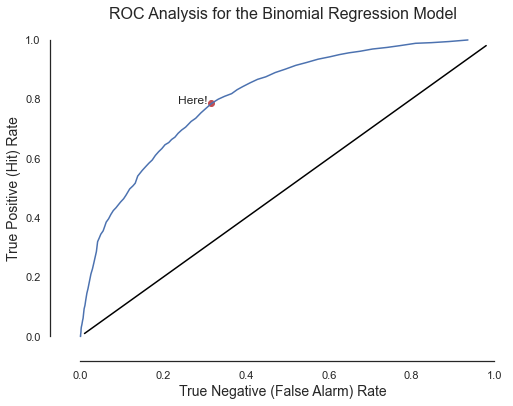

In [27]:
# - plotting the ROC curve of the model
# - the point with the biggest hit-false alarm rate difference is marked
sns.lineplot(data=roc_frame, x='dec', y='dec', color='black')
sns.lineplot(data=roc_frame, x='fa', y='hit')

plt.scatter(x=roc_frame.loc[diff_argmax, 'fa'], y=roc_frame.loc[diff_argmax, 'hit'], c='r')
plt.text(x=roc_frame.loc[diff_argmax, 'fa']-.08, y=roc_frame.loc[diff_argmax, 'hit'], s='Here!')

sns.despine(offset=10, trim=True)
plt.xlabel('True Negative (False Alarm) Rate', fontsize=14)
plt.ylabel('True Positive (Hit) Rate', fontsize=14)
plt.title('ROC Analysis for the Binomial Regression Model', fontsize=16);

In [28]:
### --- Model diagnostics

# - model log-likelihood
model_loglike = binomial_linear_model.llf
model_loglike

-3188.1130873174216

In [29]:
# - model deviance
residuals_deviance = binomial_linear_model.resid_dev
model_deviance = np.sum(residuals_deviance**2)
model_deviance

6376.226174634843

In [30]:
# - another way to compute model deviance
np.sum(residuals_deviance**2) == -2*model_loglike

True

In [31]:
# - Akaike Information Criterion (AIC)
binomial_linear_model.aic

6384.226174634843

In [32]:
# - another way to compute AIC
aic = -2*model_loglike + 2*len(predictors)
aic

6382.226174634843

In [33]:
### --- Comparison to the Null Model which follows the Chi-Square distribution

# - differenc between deviances of the Null Model and our model
dev_diff = binomial_linear_model.llr
dev_diff

1767.1289720163195

In [34]:
# - degrees of fridom
dfs = binomial_linear_model.df_model
dfs

3.0

In [35]:
# - the residuals of the model
model_residuals = binomial_linear_model.resid_response

# - calculating the p-value
sm.stats.gof.chisquare(f_obs=model_residuals, ddof=dfs)[1]

0.0

### Target: Predict churn from all the predictors

In [36]:
# - exponential of the parameters and AIC of the model using only numerical predictors (a reminder)
np.exp(binomial_linear_model.params)

Intercept         0.202133
tenure            0.935088
MonthlyCharges    1.030660
TotalCharges      1.000145
dtype: float64

In [37]:
binomial_linear_model.aic

6384.226174634843

In [38]:
### --- Prepering the dataset

# - droping the 'customerID' column
model_frame = churn_data.drop(columns='customerID')
model_frame.head()

,tenure,PhoneService,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,1,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,34,Yes,One year,No,Mailed check,56.95,1889.50,No
2,2,Yes,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,45,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,2,Yes,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [39]:
model_frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   tenure            7032 non-null   int64  
 1   PhoneService      7032 non-null   object 
 2   Contract          7032 non-null   object 
 3   PaperlessBilling  7032 non-null   object 
 4   PaymentMethod     7032 non-null   object 
 5   MonthlyCharges    7032 non-null   float64
 6   TotalCharges      7032 non-null   float64
 7   Churn             7032 non-null   object 
dtypes: float64(2), int64(1), object(5)
memory usage: 439.6+ KB


In [40]:
# - encoding 'Churn' column to binary values
model_frame['Churn'] = model_frame['Churn'].apply(lambda x: int(x == 'Yes'))
model_frame.head()

,tenure,PhoneService,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,1,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,34,Yes,One year,No,Mailed check,56.95,1889.50,0
2,2,Yes,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,45,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,2,Yes,Month-to-month,Yes,Electronic check,70.70,151.65,1


In [41]:
predictors = model_frame.columns.drop('Churn')
predictors

Index(['tenure', 'PhoneService', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges'],
      dtype='object')

In [42]:
# --- Composing the fomula of the model

# - right side of the formula
formula = ' + '.join(predictors)

# - left side of the formula
formula = 'Churn ~ ' + formula

formula

'Churn ~ tenure + PhoneService + Contract + PaperlessBilling + PaymentMethod + MonthlyCharges + TotalCharges'

In [43]:
# - fitting BLR model to the data
binomial_linear_model = smf.logit(formula=formula, data=model_frame).fit()

Optimization terminated successfully.
         Current function value: 0.424667
         Iterations 8


In [44]:
binomial_linear_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  Churn   No. Observations:                 7032
Model:                          Logit   Df Residuals:                     7021
Method:                           MLE   Df Model:                           10
Date:                Mon, 24 Apr 2023   Pseudo R-squ.:                  0.2666
Time:                        17:22:00   Log-Likelihood:                -2986.3
converged:                       True   LL-Null:                       -4071.7
Covariance Type:            nonrobust   LLR p-value:                     0.000
============================================================================================================
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
Intercept                                   -0.8446      0.176     -4.794      0.000      -1.190      -0.499
PhoneService[T.Yes]                         -0.8419      0.122     -6.926      0.000      -1.080      -0.604
Contract[T.One year]                        -0.9171      0.103     -8.876      0.000      -1.120      -0.715
Contract[T.Two year]                        -1.8135      0.172    -10.565      0.000      -2.150      -1.477
PaperlessBilling[T.Yes]                      0.4230      0.073      5.812      0.000       0.280       0.566
PaymentMethod[T.Credit card (automatic)]    -0.1006      0.112     -0.895      0.371      -0.321       0.120
PaymentMethod[T.Electronic check]            0.4126      0.093      4.453      0.000       0.231       0.594
PaymentMethod[T.Mailed check]               -0.1194      0.113     -1.061      0.289      -0.340       0.101
tenure                                      -0.0606      0.006     -9.932      0.000      -0.073      -0.049
MonthlyCharges                               0.0225      0.002     11.022      0.000       0.019       0.027
TotalCharges                                 0.0003   6.81e-05      4.205      0.000       0.000       0.000
============================================================================================================
"""

In [45]:
# - exponentials of the new model parameters
np.exp(binomial_linear_model.params)

Intercept                                   0.429725
PhoneService[T.Yes]                         0.430907
Contract[T.One year]                        0.399695
Contract[T.Two year]                        0.163084
PaperlessBilling[T.Yes]                     1.526520
PaymentMethod[T.Credit card (automatic)]    0.904265
PaymentMethod[T.Electronic check]           1.510691
PaymentMethod[T.Mailed check]               0.887475
tenure                                      0.941170
MonthlyCharges                              1.022802
TotalCharges                                1.000286
dtype: float64

In [46]:
# - AIC of the new model
binomial_linear_model.aic

5994.512151127206

In [47]:
### --- Constructing the ROC curve of the model

# - calculating model metrics for varying decision criteria \sigma
dec_criterion = np.arange(.01, .99, step=.01)

probabilities = binomial_linear_model.predict()
observations = model_frame['Churn']

hits = []
fas = []
accuracies = []

for x in dec_criterion:
    
    predictions =  probabilities > x
    
    accuracy = np.sum(observations == predictions)/len(observations)
    hit = np.sum((observations == 1)&(predictions == 1))/np.sum(observations == 1)
    fa = np.sum((observations == 0)&(predictions == 1))/np.sum(observations == 0)
    
    accuracies.append(accuracy)
    fas.append(fa)
    hits.append(hit)

In [48]:
roc_frame = pd.DataFrame()

roc_frame['hit'] = hits
roc_frame['fa'] = fas
roc_frame['accuracy'] = accuracies
roc_frame['dec'] = dec_criterion
roc_frame['diff'] = roc_frame['hit'] - roc_frame['fa']

roc_frame.head()

,hit,fa,accuracy,dec,diff
0,0.996255,0.872942,0.358077,0.01,0.123313
1,0.990904,0.791788,0.416240,0.02,0.199117
2,0.986624,0.731551,0.459329,0.03,0.255072
3,0.983414,0.688166,0.490330,0.04,0.295248
4,0.979668,0.653883,0.514505,0.05,0.325785


In [49]:
# - identifying the entry with the highest hit-false alarm rate difference
diff_argmax = roc_frame['diff'].argmax()
diff_argmax

23

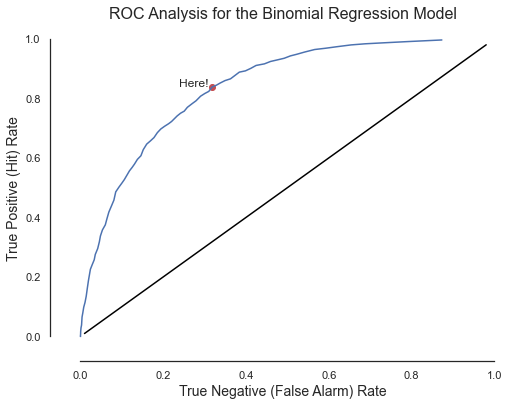

In [50]:
# - plotting the ROC curve of the model
# - the point with the biggest hit-false alarm rate difference is marked
sns.lineplot(data=roc_frame, x='dec', y='dec', color='black')
sns.lineplot(data=roc_frame, x='fa', y='hit')

plt.scatter(x=roc_frame.loc[diff_argmax, 'fa'], y=roc_frame.loc[diff_argmax, 'hit'], c='r')
plt.text(x=roc_frame.loc[diff_argmax, 'fa']-.08, y=roc_frame.loc[diff_argmax, 'hit'], s='Here!')

sns.despine(offset=10, trim=True)
plt.xlabel('True Negative (False Alarm) Rate', fontsize=14)
plt.ylabel('True Positive (Hit) Rate', fontsize=14)
plt.title('ROC Analysis for the Binomial Regression Model', fontsize=16);

## 2. BLR using scikit-learn

### Target: Predicting churn from numerical predictors

In [51]:
# - import scikit-learn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [52]:
### --- Preparing the variables 

# - feature matrix
X = churn_data[['tenure', 'MonthlyCharges', 'TotalCharges']].values

# - target variable
y = churn_data['Churn'].apply(lambda x: int(x == 'Yes'))

In [53]:
## --- Fitting the logistic model to the numerical data
log_reg = LogisticRegression()
log_reg.fit(X, y)

LogisticRegression()

In [54]:
# - coefficients of the model
log_reg.coef_, log_reg.intercept_

(array([[-0.06711264,  0.03019993,  0.00014507]]), array([-1.59884834]))

In [55]:
# - exponentials of the model coefficients
np.exp(log_reg.coef_), np.exp(log_reg.intercept_)

(array([[0.93508987, 1.03066058, 1.00014508]]), array([0.20212917]))

In [56]:
# - model's accuracy
round(log_reg.score(X, y), 4)

0.785

In [57]:
# - confusion matrix for the given data
y_pred = log_reg.predict(X)
confusion_matrix(y, y_pred)

array([[4693,  470],
       [1042,  827]], dtype=int64)

### Target: Predicting churn from all the predictors

In [58]:
churn_data.head()

,customerID,tenure,PhoneService,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,1,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,34,Yes,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,2,Yes,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,45,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,2,Yes,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [59]:
### --- Composing the feature matrix

# - dropping all the non-numerical and non-binary categorical columns
X0 = churn_data.drop(columns=['customerID', 'Contract', 'PaymentMethod', 'Churn'])

# - encoding binary categorical features to binary values
X0['PaperlessBilling'] = X0['PaperlessBilling'].apply(lambda x: int(x == 'Yes'))
X0['PhoneService'] = X0['PhoneService'].apply(lambda x: int(x == 'Yes'))

X0.head()

,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges
0,1,0,1,29.85,29.85
1,34,1,0,56.95,1889.50
2,2,1,1,53.85,108.15
3,45,0,0,42.30,1840.75
4,2,1,1,70.70,151.65


In [60]:
# - casting the data frame into a matrix
X0 = X0.values

In [61]:
# - categories of the 'Contract' variable
churn_data['Contract'].unique()

array(['Month-to-month', 'One year', 'Two year'], dtype=object)

In [62]:
# - categories of the 'PaymentMethod' variable
churn_data['PaymentMethod'].unique()

array(['Electronic check', 'Mailed check', 'Bank transfer (automatic)',
       'Credit card (automatic)'], dtype=object)

In [63]:
# - we want to recreate the previous statsmodels model that was using all the predictors
# - to achieve this we one-hot (dummy) encode non-binary categorical predictors
# - statsmodels chooses the first category in order of appearance in the dataset as the reference category
# - we pass the reference category manually as an argument to the OneHotEncoder

enc_contract = OneHotEncoder(drop=['Month-to-month'], sparse=False)
dummy_contract = enc_contract.fit_transform(churn_data['Contract'].values.reshape(-1, 1))

enc_payment = OneHotEncoder(drop=['Bank transfer (automatic)'], sparse=False)
dummy_payment = enc_payment.fit_transform(churn_data['PaymentMethod'].values.reshape(-1, 1))

In [64]:
# - concatenating values of the numerical predictors and encoded binary values with the encoded non-binary values
# - into a feature matrix
X = np.concatenate((X0, dummy_contract, dummy_payment), axis=-1)

# - target variable; encoding to binary values
y = churn_data['Churn'].apply(lambda x: int(x == 'Yes'))

In [65]:
### --- Fitting the logistic model to all the data
# - the hyperparameters are selected as to recreate the statsmode's model
# - experimenting with hyperparameters is encouraged
log_reg = LogisticRegression(solver='newton-cg', penalty='none')
log_reg.fit(X, y)

LogisticRegression(penalty='none', solver='newton-cg')

In [66]:
# - model's accuracy
round(log_reg.score(X, y), 4)

0.7964

In [67]:
# - exponential of the model parameters
# - ordering corresponds to the ordering of the features in the feature matrix
np.exp(log_reg.coef_), np.exp(log_reg.intercept_)

(array([[0.9411695 , 0.43090698, 1.52652008, 1.0228018 , 1.00028639,
         0.39969521, 0.16308371, 0.90426493, 1.51069097, 0.88747495]]),
 array([0.42972508]))

In [68]:
# - confusion matrix for the given data
y_pred = log_reg.predict(X)
confusion_matrix(y, y_pred)

array([[4615,  548],
       [ 884,  985]], dtype=int64)

## 3. MLEs for Binomial Logistic Regression

## 4. Multinomial Logistic Regression

In [69]:
# - loading the dataset
# - Kaggle: https://www.kaggle.com/datasets/uciml/iris
# - place it in your _data/ directory
iris_data = pd.read_csv(os.path.join(data_dir, 'Iris.csv'), index_col='Id')
iris_data.head(10)

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
Id,,,,,
1,5.1,3.5,1.4,0.2,Iris-setosa
2,4.9,3.0,1.4,0.2,Iris-setosa
3,4.7,3.2,1.3,0.2,Iris-setosa
4,4.6,3.1,1.5,0.2,Iris-setosa
5,5.0,3.6,1.4,0.2,Iris-setosa
6,5.4,3.9,1.7,0.4,Iris-setosa
7,4.6,3.4,1.4,0.3,Iris-setosa
8,5.0,3.4,1.5,0.2,Iris-setosa
9,4.4,2.9,1.4,0.2,Iris-setosa


In [70]:
# - counting the instances of each category
iris_data['Species'].value_counts()

Iris-setosa        50
Iris-versicolor    50
Iris-virginica     50
Name: Species, dtype: int64

In [71]:
# - info on the variables
iris_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150 entries, 1 to 150
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   SepalLengthCm  150 non-null    float64
 1   SepalWidthCm   150 non-null    float64
 2   PetalLengthCm  150 non-null    float64
 3   PetalWidthCm   150 non-null    float64
 4   Species        150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 7.0+ KB


### Target: predict species from all continuous predictors

We use Multinomial Logistic Regression Model to predict the most probable category for the given observation $\textbf{x}$ with features $(x_1, x_2, \ldots, x_k)$. Assume that our target variable $y$ belongs to one of categories from the set $\{1, 2, \ldots, C\}$. In MNR we usually select one category as the referrence category; let that be the category $C$. Then, the probability that the target variable $y$ belongs to category $c = 1,\ldots,C-1$ is calculated via

$$P(y = c) = \frac{e^{\beta^{(c)}_1x_1 + \beta^{(c)}_2x_2 + \cdots + \beta^{(c)}_kx_k + \beta_0}}{1+\sum_{j=1}^{C-1}e^{\beta^{(j)}_1x_1 + \beta^{(j)}_2x_2 + \cdots + \beta^{(j)}_kx_k + \beta_0}},$$

and the probability that it belogns to the referrence category $C$ is 

$$P(y = C) = \frac{1}{1+\sum_{j=1}^{C-1}e^{\beta^{(j)}_1x_1 + \beta^{(j)}_2x_2 + \cdots + \beta^{(j)}_kx_k + \beta_0}},$$

where $\beta^{(j)}_1, \beta^{(j)}_2, \ldots, \beta^{(j)}_k,\ j=1,\ldots,C$ are the model's parameters for predictors and target variable categories, and $n$ is the intercept of the model.

After calculating all the probabilities $P(y = c),\ c=1,\ldots,C$ we predict the target variable as

$$\hat{y} = \textrm{argmax}_{c=1,\ldots,C}P(y=c).$$

The model is estimated by MLE (Maximum Likelihood Estimation). For each category $c$ - except for the referrence $C$, of course - we obtain a set of coefficients. Each model coefficient, in each category, tells us about the $\Delta_{odds}$ in favor of the target category, for a unit change of a predictor, in comparison with the baseline category, and given that everything else is kept constant.

In [72]:
### --- Preparing the variables 

# - feature matrix
X = iris_data.drop(columns='Species')
# - we append a constant column of ones to the feature matrix
X = sm.add_constant(X)
print(X[:10])


# - we impose the ordering to the categories of the target vector; the first category is the referrence category
cat_type = pd.CategoricalDtype(categories=["Iris-versicolor", "Iris-virginica", "Iris-setosa"], ordered=True)
y = iris_data['Species'].astype(cat_type)

    const  SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm
Id                                                                 
1     1.0            5.1           3.5            1.4           0.2
2     1.0            4.9           3.0            1.4           0.2
3     1.0            4.7           3.2            1.3           0.2
4     1.0            4.6           3.1            1.5           0.2
5     1.0            5.0           3.6            1.4           0.2
6     1.0            5.4           3.9            1.7           0.4
7     1.0            4.6           3.4            1.4           0.3
8     1.0            5.0           3.4            1.5           0.2
9     1.0            4.4           2.9            1.4           0.2
10    1.0            4.9           3.1            1.5           0.1


In [83]:
# - fitting the MNR model to the data; we use the Newton's Conjugate Gradient method as the optimizer to compute the
#models coefficients
mnr_model = sm.MNLogit(exog=X, endog=y).fit(method='ncg', maxiter=150)
mnr_model.summary()

Optimization terminated successfully.
         Current function value: 0.039663
         Iterations: 116
         Function evaluations: 117
         Gradient evaluations: 117
         Hessian evaluations: 116


<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:                Species   No. Observations:                  150
Model:                        MNLogit   Df Residuals:                      140
Method:                           MLE   Df Model:                            8
Date:                Mon, 24 Apr 2023   Pseudo R-squ.:                  0.9639
Time:                        17:33:57   Log-Likelihood:                -5.9494
converged:                       True   LL-Null:                       -164.79
Covariance Type:            nonrobust   LLR p-value:                 7.056e-64
=======================================================================================
Species=Iris-virginica       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                    -42.6378     25.707     -1.659      0.097     -93.023       7.748
SepalLengthCm             -2.4650      2.394     -1.030      0.303      -7.158       2.228
SepalWidthCm              -6.6814      4.480     -1.491      0.136     -15.461       2.099
PetalLengthCm              9.4294      4.737      1.990      0.047       0.145      18.714
PetalWidthCm              18.2859      9.743      1.877      0.061      -0.809      37.381
------------------------------------------------------------------------------------------
Species=Iris-setosa       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   1.2464   2814.348      0.000      1.000   -5514.774    5517.267
SepalLengthCm           2.1570    796.124      0.003      0.998   -1558.216    1562.531
SepalWidthCm            6.3632    392.430      0.016      0.987    -762.785     775.511
PetalLengthCm         -10.6666    514.181     -0.021      0.983   -1018.443     997.110
PetalWidthCm           -5.4860    974.930     -0.006      0.996   -1916.313    1905.341
=======================================================================================
"""

In [84]:
# - confusion matrix for our model and given data; rows/columns are on par with the ordering of categorical variable
mnr_model.pred_table()

array([[49.,  1.,  0.],
       [ 1., 49.,  0.],
       [ 0.,  0., 50.]])

In [85]:
# - accuracy of the model
print(f'The accuracy of our model: {round(148/150, 4)}')

The accuracy of our model: 0.9867


In [86]:
# - model's prediction of probabilities; columns correspond to the ordering of categorical variable
mnr_model.predict()[:10]

array([[9.34872753e-09, 1.44324732e-35, 9.99999991e-01],
       [3.46621493e-07, 2.47392957e-32, 9.99999653e-01],
       [5.14366413e-08, 6.15260257e-34, 9.99999949e-01],
       [1.01809267e-06, 2.00366351e-31, 9.99998982e-01],
       [6.13878953e-09, 6.21664320e-36, 9.99999994e-01],
       [2.82201171e-08, 9.42229344e-34, 9.99999972e-01],
       [8.98984023e-08, 5.77985326e-33, 9.99999910e-01],
       [6.36830880e-08, 6.30010984e-34, 9.99999936e-01],
       [1.92574911e-06, 9.19522343e-31, 9.99998074e-01],
       [3.07960805e-07, 4.64760530e-33, 9.99999692e-01]])

In [87]:
# - model's prediction of categories; numbers correspond to the ordering of categorical variable
preds = np.argmax(mnr_model.predict(), axis=-1)
preds

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

### Multicolinearity in Multinomial Regression

In [88]:
### --- Step 1: recode categorical target variable to integer values, 
# - just in order to be able to run a multiple linear regression on the data:
y = y.cat.codes
y

Id
1      2
2      2
3      2
4      2
5      2
      ..
146    1
147    1
148    1
149    1
150    1
Length: 150, dtype: int8

In [89]:
### --- Step 2: produce a Multiple Linear Regression model for the data 
mnr_model = sm.OLS(exog=X, endog=y).fit()
mnr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.571
Model:                            OLS   Adj. R-squared:                  0.559
Method:                 Least Squares   F-statistic:                     48.17
Date:                Mon, 24 Apr 2023   Prob (F-statistic):           1.02e-25
Time:                        17:35:19   Log-Likelihood:                -119.03
No. Observations:                 150   AIC:                             248.1
Df Residuals:                     145   BIC:                             263.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.4405      0.509     -0.866      0.388      -1.446       0.565
SepalLengthCm     0.0872      0.143      0.608      0.544      -0.196       0.371
SepalWidthCm      0.6832      0.149      4.586      0.000       0.389       0.978
PetalLengthCm    -0.4413      0.142     -3.117      0.002      -0.721      -0.161
PetalWidthCm      0.4198      0.235      1.789      0.076      -0.044       0.884
==============================================================================
Omnibus:                       28.857   Durbin-Watson:                   0.448
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                7.904
Skew:                          -0.222   Prob(JB):                       0.0192
Kurtosis:                       1.966   Cond. No.                         91.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [90]:
# --- Step 3: compute VIFs for the predictors
predictors = iris_data.columns.drop('Species')
predictors

Index(['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm'], dtype='object')

In [91]:
# - appending the columns of ones to the predictors' data
model_frame_predictors = sm.add_constant(iris_data[predictors])

In [94]:
# - computing VIFs
vifs = [variance_inflation_factor(model_frame_predictors.values, i) for i in range(1, len(predictors)+1)]
vifs = np.array(vifs).reshape(1, -1)
vifs
pd.DataFrame(vifs, columns=predictors)

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
0,7.103113,2.099039,31.397292,16.141564


### Multinomial Logistic Regression using scikit-learn

In [95]:
# - import scikit-learn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

In [96]:
### --- Preparing the variables 

# - feature matrix
X = iris_data.drop(columns='Species').values

# - target variable
y = iris_data['Species']

In [97]:
### --- Fitting the logistic model to the numerical data
# - scikit-learn does not implement the referrence category automatically 
# - experiment with hyperparameters to produce more accurate model
log_reg = LogisticRegression(solver='newton-cg', penalty='none')
log_reg.fit(X, y)

LogisticRegression(penalty='none', solver='newton-cg')

In [98]:
# - coefficents of the model; rows correspond to the order of appearance of categories in the target variable
log_reg.coef_, log_reg.intercept_

(array([[  4.88501685,   7.84683378, -12.83914117,  -6.66236914],
        [ -1.20989943,  -0.58296936,   1.70486765,  -5.81189786],
        [ -3.67511742,  -7.26386442,  11.13427351,  12.47426701]]),
 array([  2.32878337,  20.15458005, -22.48336342]))

In [99]:
# - model's accuracy
round(log_reg.score(X, y), 4)

0.9867

In [100]:
# - predictions
y_pred = log_reg.predict(X)
y_pred[:10]

array(['Iris-setosa', 'Iris-setosa', 'Iris-setosa', 'Iris-setosa',
       'Iris-setosa', 'Iris-setosa', 'Iris-setosa', 'Iris-setosa',
       'Iris-setosa', 'Iris-setosa'], dtype=object)

In [101]:
# - confusion matrix for the given data
# - rows/columns rows correspond to the order of appearance of categories in the target variable
confusion_matrix(y, y_pred)

array([[50,  0,  0],
       [ 0, 49,  1],
       [ 0,  1, 49]], dtype=int64)

## 5. Regularization of MLR

In [102]:
# - loading the dataset
# - UCI ML: https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/) (download winequality-red.csv)
# - place it in your _data/ directory
wine_data = pd.read_csv(os.path.join(data_dir, 'winequality-red.csv'), sep=';')
wine_data.head(10)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
5,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,5
6,7.9,0.60,0.06,1.6,0.069,15.0,59.0,0.9964,3.30,0.46,9.4,5
7,7.3,0.65,0.00,1.2,0.065,15.0,21.0,0.9946,3.39,0.47,10.0,7
8,7.8,0.58,0.02,2.0,0.073,9.0,18.0,0.9968,3.36,0.57,9.5,7
9,7.5,0.50,0.36,6.1,0.071,17.0,102.0,0.9978,3.35,0.80,10.5,5


### Target: predict wine quality from all the predictors

In [103]:
wine_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [104]:
predictors = wine_data.columns.drop('quality')
predictors

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol'],
      dtype='object')

In [105]:
# - converting 'quality' variable which is numerical into ordered categorical
wine_data['quality'] = wine_data['quality'].astype(pd.CategoricalDtype(ordered=True))
wine_data['quality'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 1599 entries, 0 to 1598
Series name: quality
Non-Null Count  Dtype   
--------------  -----   
1599 non-null   category
dtypes: category(1)
memory usage: 1.9 KB


In [106]:
wine_data['quality'].head()

0    5
1    5
2    5
3    6
4    5
Name: quality, dtype: category
Categories (6, int64): [3 < 4 < 5 < 6 < 7 < 8]

In [107]:
wine_data['quality'].value_counts()

5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64

In [108]:
### --- Preparing the variables 

# - feature matrix
X = wine_data.drop(columns='quality')
# - we append a constant column of ones to the feature matrix
X = sm.add_constant(X)

# - target vector
y = wine_data['quality']

In [109]:
# - fitting the MNR model to the data; we use the Newton's Conjugate Gradient method as the optimizer to compute the
#models coefficients
mnr_model = sm.MNLogit(exog=X, endog=y).fit(method='ncg', maxiter=100)
mnr_model.summary()

Optimization terminated successfully.
         Current function value: 0.913760
         Iterations: 46
         Function evaluations: 78
         Gradient evaluations: 78
         Hessian evaluations: 46


<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:                quality   No. Observations:                 1599
Model:                        MNLogit   Df Residuals:                     1539
Method:                           MLE   Df Model:                           55
Date:                Mon, 24 Apr 2023   Pseudo R-squ.:                  0.2287
Time:                        17:41:18   Log-Likelihood:                -1461.1
converged:                       True   LL-Null:                       -1894.2
Covariance Type:            nonrobust   LLR p-value:                2.987e-146
========================================================================================
           quality=4       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  150.7854    547.752      0.275      0.783    -922.789    1224.360
fixed acidity           -0.6119      0.688     -0.889      0.374      -1.961       0.737
volatile acidity        -4.8509      2.448     -1.981      0.048      -9.649      -0.052
citric acid             -2.3627      4.063     -0.581      0.561     -10.326       5.601
residual sugar           0.1666      0.312      0.533      0.594      -0.446       0.779
chlorides              -10.3956      7.560     -1.375      0.169     -25.212       4.421
free sulfur dioxide     -0.1601      0.091     -1.757      0.079      -0.339       0.018
total sulfur dioxide     0.0839      0.050      1.678      0.093      -0.014       0.182
density               -131.9670    557.829     -0.237      0.813   -1225.292     961.358
pH                      -7.1129      5.073     -1.402      0.161     -17.056       2.831
sulphates                1.1854      3.746      0.316      0.752      -6.156       8.527
alcohol                  1.5048      0.877      1.715      0.086      -0.215       3.225
----------------------------------------------------------------------------------------
           quality=5       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 -104.0851    522.960     -0.199      0.842   -1129.067     920.897
fixed acidity           -0.9018      0.651     -1.386      0.166      -2.177       0.373
volatile acidity        -7.8053      2.408     -3.241      0.001     -12.525      -3.086
citric acid             -2.7974      3.904     -0.716      0.474     -10.450       4.855
residual sugar          -0.1348      0.298     -0.453      0.651      -0.719       0.449
chlorides              -12.8486      6.884     -1.867      0.062     -26.340       0.643
free sulfur dioxide     -0.1366      0.088     -1.545      0.122      -0.310       0.037
total sulfur dioxide     0.0994      0.049      2.011      0.044       0.003       0.196
density                143.4813    532.630      0.269      0.788    -900.455    1187.417
pH                     -10.8172      4.888     -2.213      0.027     -20.398      -1.237
sulphates                0.9416      3.538      0.266      0.790      -5.994       7.877
alcohol                  1.4625      0.852      1.717      0.086      -0.207       3.132
----------------------------------------------------------------------------------------
           quality=6       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  -71.9561    524.277     -0.137      0.891   -1099.519     955.607
fixed acidity           -0.7707      0.651     -1.184      0.236      -2.046       0.505
volatile acidity       -10.4437      2.432     -4.294      0.000     -15.211      -5.676
citric acid             -4.0991      

In [110]:
# - confusion matrix for the model prdictions; ordering of rows/columns correspond to the oredering of the classes
conf_matrix = mnr_model.pred_table()
conf_matrix

array([[  2.,   0.,   7.,   1.,   0.,   0.],
       [  1.,   1.,  34.,  15.,   2.,   0.],
       [  2.,   0., 514., 159.,   6.,   0.],
       [  0.,   0., 207., 391.,  40.,   0.],
       [  0.,   0.,  13., 120.,  66.,   0.],
       [  0.,   0.,   0.,  10.,   8.,   0.]])

In [111]:
# - accuracy of the model
mnr_acc = np.sum(np.diag(conf_matrix))/np.sum(conf_matrix)
mnr_acc

0.6091307066916823

### Ridge (L2) Regularization

Now we are going to use scikit-learn to perform *Regularized* Multinomial Logistic Regression; we'll be using the Ridge Regression. 

The Ridge Regression model is obtained by minimizing the function

$$-C\cdot LL + \frac{1}{2}L_2^2,$$

where $LL$ is Log-Likelihood of the 'ordinary' MNR, and $L_2^2$ is the squared *Frobenius norm* of model parameters matrix $W$:

$$L_2^2 = ||W||_F^2 = \sum_{i=1}^k\sum_{j=1}^K(\beta_i^{(j)})^2;$$

$k$ is the number of predictors, $K$ number of categories of the targert variable, and $\beta_i^{(j)}$ are model parameters. $C$ is the *Regularization (hyper)parameter* and it the invers of penalization hyperparameter $\alpha$.

In [112]:
# - import scikit-learn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

In [113]:
### --- Preparing the variables 

# - feature matrix
X = wine_data.drop(columns='quality').values

# - target variable
y = wine_data['quality']

In [114]:
### --- Fitting a Ridge MNR Regularized model on the given data, with the regularization parameter C = 250

# - NOTE: LogisticRegression from scikit-learn implements L2 regularization BY DEFAULT
# - so, you actually don't need to pass 'penalty' parameter in order to implement Ridge Regularization
# - if you want to perform MNR without any regularization with scikit-learn, you need to pass 'penalty=none' parameter

log_reg = LogisticRegression(solver='newton-cg', penalty='l2', C=250)
log_reg.fit(X, y)

LogisticRegression(C=250, solver='newton-cg')

In [115]:
# - intercept of the model; entries correspond to the orderdering of the categories in the target variable 
log_reg.intercept_

array([-21.92075208,   1.95548122,   8.43134916,   2.14612481,
         2.8028652 ,   6.58493168])

In [116]:
# - coefficents of the model; rows correspond to the ordering of the categories in the target variable;
# - columns correspond to the predictors
log_reg.coef_

array([[ 6.14803951e-01,  7.56763474e+00,  2.45865287e+00,
         1.14608834e-02,  1.40139205e+01,  1.04510711e-01,
        -6.66259221e-02,  3.69122587e-01,  8.72678197e+00,
        -2.72743545e+00, -1.87880504e+00],
       [-1.13518559e-01,  2.80313116e+00,  1.59509973e-01,
         1.14656962e-01,  5.27580878e+00, -5.30471209e-02,
         1.69277450e-02, -3.07275513e+00,  1.44599702e+00,
        -2.27686797e+00, -3.21108286e-01],
       [-1.08836596e-01, -2.44317524e-01, -5.78272970e-01,
        -7.99026847e-02,  3.61521325e+00, -3.29943230e-02,
         3.37384507e-02,  4.80080982e+00, -7.93598622e-01,
        -2.17469094e+00, -5.90818556e-01],
       [-1.57653049e-02, -2.89753100e+00, -1.86281805e+00,
        -4.66663039e-02,  9.91879988e-01, -1.13792937e-02,
         1.73276089e-02,  3.33634205e+00, -9.78561474e-01,
         1.27877313e-01,  2.27470082e-01],
       [ 3.77687787e-02, -5.39289727e+00, -1.43891422e+00,
         9.54358594e-02, -6.43978670e+00, -6.89353735e-03,
  

In [117]:
# - accuracy of Ridge Regularization
log_reg.score(X, y)

0.610381488430269

In [118]:
# - accuracy of statsmodel's MNR model without the regularization
mnr_acc

0.6091307066916823

In [119]:
### --- Varying the regularization parameter for the Ridge Regularized Model
n_Cs = 25
Cs = np.linspace(1e-2, 500, n_Cs)

l2_coefs = []
accuracies = []
frob_norms_matrix = []
for C in Cs:
    
    # - fitting a Ridge Regularization
    ridge = LogisticRegression(solver='newton-cg', C=C, max_iter=1000)
    ridge.fit(X, y)
    
    # - squared L2 norm of model coefficients vectors for each category
    l2_c = np.linalg.norm(ridge.coef_, ord=2, axis=0)**2
    
    # - accuracy of a fitted Regularized Model
    acc = ridge.score(X, y)
    
    # - squared Frobenius norm of model coefficient matrix
    frob = np.linalg.norm(ridge.coef_, ord=2)**2
    
    l2_coefs.append(l2_c)
    accuracies.append(acc)
    frob_norms_matrix.append(frob)

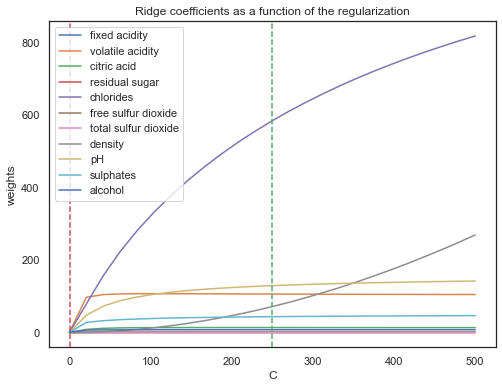

In [120]:
### --- Plotting the dependence of model parameters vs. the regularization hyperparameter
ax = plt.gca()

ax.plot(Cs, l2_coefs)
ax.axvline(x=1, c='r', ls='--') # red line, corresponding to C = 0
ax.axvline(x=250, c='g', ls='--') # green line, corresponding to C = 250
plt.xlabel("C")
plt.ylabel("weights")
plt.title("Ridge coefficients as a function of the regularization")
plt.axis("tight")
plt.legend(predictors)
plt.show()

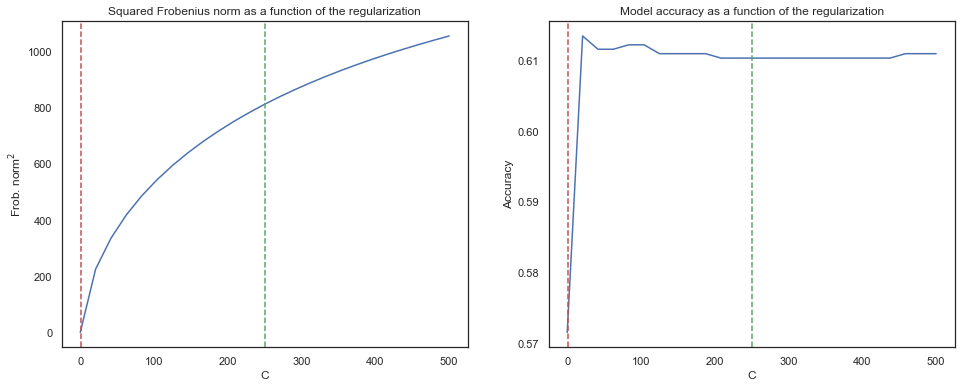

In [121]:
### --- Plotting the dependance of various model metrics vs. the regularization hyperparameter
ig, ax = plt.subplots(1, 2, figsize=(16, 6), sharex=True)


# - squared Frobenius vs. C
ax[0].plot(Cs, frob_norms_matrix)
ax[0].axvline(x=1, c='r', ls='--') # red line, corresponding to C = 1
ax[0].axvline(x=250, c='g', ls='--') # green line, corresponding to C = 250
ax[0].set_xlabel("C")
ax[0].set_ylabel("Frob. norm$^2$")
ax[0].set_title("Squared Frobenius norm as a function of the regularization")
ax[0].axis("tight")

# - accuracy vs. C
ax[1].plot(Cs, accuracies)
ax[1].axvline(x=1, c='r', ls='--') # red line
ax[1].axvline(x=250, c='g', ls='--') # green line
ax[1].set_xlabel("C")
ax[1].set_ylabel("Accuracy")
ax[1].set_title("Model accuracy as a function of the regularization")
ax[1].axis("tight");

From the right graph above, we may assume that for regularization hyperparameter C ~ 12.5 we may obtain a good approximation of the best model.

In [122]:
### --- Fitting an assumed approximation of the best Ridge Regularized model
ridge_best = LogisticRegression(C=12.5, solver='newton-cg')
ridge_best.fit(X, y)

LogisticRegression(C=12.5, solver='newton-cg')

In [123]:
ridge_best.intercept_

array([-5.36870319, -0.40200138, 11.58437309,  3.49235553, -4.55844927,
       -4.74757479])

In [124]:
ridge_best.coef_

array([[ 3.45549775e-01,  6.58733940e+00,  1.36310056e+00,
         9.23288000e-02,  3.03620804e+00,  8.65226195e-02,
        -6.34795536e-02,  2.68289765e-02,  3.83621757e+00,
        -1.03498214e+00, -1.53389937e+00],
       [-1.28796833e-01,  2.91022314e+00,  4.25363277e-01,
         1.16383928e-01,  1.81702215e+00, -4.80549423e-02,
         1.45603721e-02, -1.43138264e-01,  1.44750820e+00,
        -1.93177259e+00, -3.85766308e-01],
       [-8.69221363e-02,  6.00823040e-02, -1.86469471e-01,
        -7.78867289e-02,  2.24085323e+00, -2.76364534e-02,
         3.12840393e-02,  2.63178557e-01, -2.91219185e-01,
        -2.28454575e+00, -6.66343573e-01],
       [ 1.11162390e-02, -2.53942397e+00, -1.44085328e+00,
        -4.64611861e-02,  2.20915151e-01, -6.14488130e-03,
         1.49491281e-02,  1.89260606e-01, -3.73775558e-01,
        -1.14570432e-01,  1.55758454e-01],
       [ 6.53378941e-02, -5.04475830e+00, -1.07785365e+00,
         8.43238762e-02, -4.14733996e+00, -2.33029029e-03,
  

In [125]:
# - accuracy of our model
ridge_best.score(X, y)

0.6128830519074422

### LASSO (L1) Regularization

*LASSO* is another way to regularize MNR model. It's obtained by minimizing the function

$$-C\cdot LL + \frac{1}{2}L_1,$$

where $LL$ is Log-Likelihood of the 'ordinary' MNR, and $L_1$ is the $L_1$ norm of model parameters matrix $W$:

$$L_1 = ||W||_1 = \sum_{i=1}^k\sum_{j=1}^K|\beta_i^{(j)}|.$$

$C$ is, of course regularization hyperparameter.

Both Ridge and LASSO Regularizations are a part of a more general *Elastic-net* Regularization, obtaned by minimizing the function 

$$-C\cdot LL + \rho L_1 + \frac{1 - \rho}{2}L_2^2$$

where $\rho\in[0,1]$ is yet another hyperparameter. For $\rho = 0$ one recovers Ridge Regularization, and for $\rho = 1$ LASSO Regularization.

In [126]:
### --- Varying the penalization parameter for the LASSO Regularized Model
n_Cs = 25
Cs = np.linspace(1e-2, 500, n_Cs)

l1_coefs = []
accuracies = []
l1_norms_matrix = []
for C in Cs:
    # - fitting a LASSO Regularization
    ridge = LogisticRegression(solver='liblinear', penalty='l1', C=C, max_iter=1000)
    ridge.fit(X, y)
    
    # - L1 norm of model coefficients vectors for each category
    l1_c = np.linalg.norm(ridge.coef_, ord=1, axis=0)
    
    # - accuracy of a fitted Regularized Model
    acc = ridge.score(X, y)
    
    # - L1 norm of model coefficient matrix
    l1_m = np.linalg.norm(ridge.coef_, ord=1)
    
    l1_coefs.append(l1_c)
    accuracies.append(acc)
    l1_norms_matrix.append(l1_m)

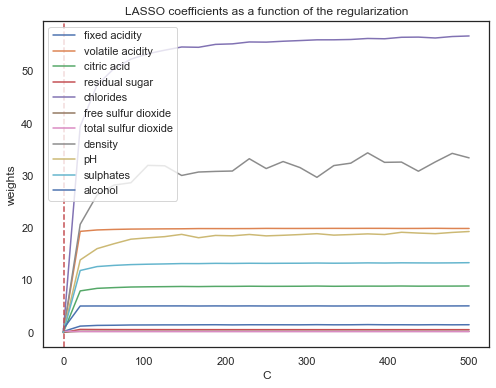

In [128]:
### --- Plotting the dependence of model parameters vs. the regularization hyperparameter
ax = plt.gca()

ax.plot(Cs, l1_coefs)
ax.axvline(x=1, c='r', ls='--') # red line, corresponding to C = 1
plt.xlabel("C")
plt.ylabel("weights")
plt.title("LASSO coefficients as a function of the regularization")
plt.axis("tight")
plt.legend(predictors)
plt.show()

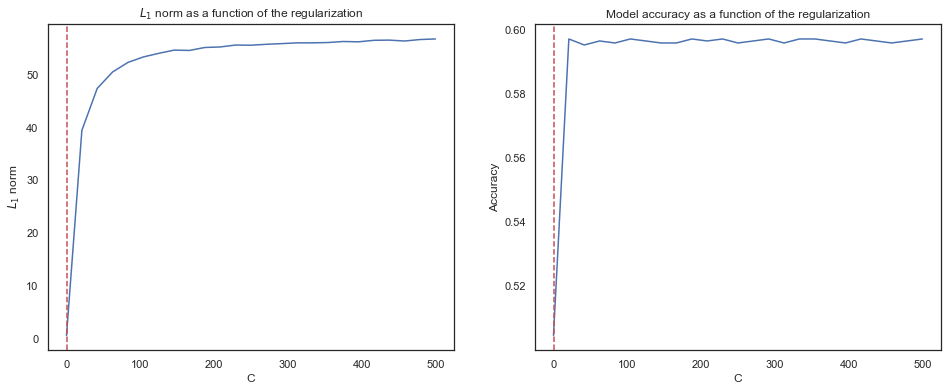

In [129]:
### --- Plotting the dependance of various model metrics vs. the regularization hyperparameter
ig, ax = plt.subplots(1, 2, figsize=(16, 6), sharex=True)


# - L1-norm vs. C
ax[0].plot(Cs, l1_norms_matrix)
ax[0].axvline(x=1, c='r', ls='--') # red line
ax[0].set_xlabel("C")
ax[0].set_ylabel("$L_1$ norm")
ax[0].set_title("$L_1$ norm as a function of the regularization")
ax[0].axis("tight")

# - Model accuracy vs. C
ax[1].plot(Cs, accuracies)
ax[1].axvline(x=1, c='r', ls='--') # red line
ax[1].set_xlabel("C")
ax[1].set_ylabel("Accuracy")
ax[1].set_title("Model accuracy as a function of the regularization")
ax[1].axis("tight");

In [130]:
# - fitting an assumed best approximation for C = 12.5
lasso_best = LogisticRegression(C=12.5, solver='liblinear', penalty='l1')
lasso_best.fit(X, y)

LogisticRegression(C=12.5, penalty='l1', solver='liblinear')

In [131]:
lasso_best.intercept_

array([-6.78867169, -2.93809375,  4.10616238, -1.47719585, -4.21432216,
        0.        ])

In [132]:
lasso_best.coef_

array([[ 3.64844742e-01,  7.90397242e+00,  2.08003448e+00,
         8.57185151e-02,  6.59233075e+00,  1.24899543e-01,
        -9.27420756e-02, -2.75631089e+00,  3.80479547e+00,
        -2.94578514e-01, -1.62495141e+00],
       [-1.43529973e-01,  3.72320910e+00,  7.92457116e-01,
         1.74363470e-01,  9.33308461e-01, -2.60738184e-02,
        -1.04456861e-02, -2.56915966e+00,  1.33439983e+00,
        -9.16365459e-01, -2.65261811e-01],
       [-7.59283476e-02,  1.72046772e+00,  5.97307887e-01,
        -6.28850559e-02,  2.97500485e+00, -1.96127656e-02,
         1.86497490e-02,  4.79754623e+00,  1.14894982e-01,
        -2.38232004e+00, -8.85936701e-01],
       [ 6.95271856e-02, -1.70235079e+00, -1.30797393e+00,
        -2.11108184e-02, -1.63831200e-01,  2.30622529e-02,
        -1.22762363e-02, -1.29839274e+00,  1.59676925e-01,
         8.75552913e-01,  2.07903800e-01],
       [ 7.05694939e-02, -3.45556951e+00, -6.50683591e-02,
         1.38549637e-01, -7.42584879e+00,  1.29783269e-02,
  

In [133]:
lasso_best.score(X, y)

0.5972482801751094

In [134]:
mnr_acc

0.6091307066916823

### Further Reading

***

DataKolektiv, 2022/23.

[hello@datakolektiv.com](mailto:goran.milovanovic@datakolektiv.com)

![](../img/DK_Logo_100.png)

<font size=1>License: [GPLv3](https://www.gnu.org/licenses/gpl-3.0.txt) This Notebook is free software: you can redistribute it and/or modify it under the terms of the GNU General Public License as published by the Free Software Foundation, either version 3 of the License, or (at your option) any later version. This Notebook is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU General Public License for more details. You should have received a copy of the GNU General Public License along with this Notebook. If not, see http://www.gnu.org/licenses/.</font>